## Exercises 🛠

1. Play with neural networks in the [TensorFlow Playground](https://playground.tensorflow.org/) for 10-minutes. Especially try different values of the learning, what happens when you decrease it? What happens when you increase it?
2. Replicate the model pictured in the [TensorFlow Playground diagram](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true) below using TensorFlow code. Compile it using the Adam optimizer, binary crossentropy loss and accuracy metric. Once it's compiled check a summary of the model.
![tensorflow playground example neural network](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-replication-exercise.png)
*Try this network out for yourself on the [TensorFlow Playground website](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=6,6,6,6,6&seed=0.51287&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&discretize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&dataset_hide=true&problem_hide=true&noise_hide=true&batchSize_hide=true). Hint: there are 5 hidden layers but the output layer isn't pictured, you'll have to decide what the output layer should be based on the input data.*
3. Create a classification dataset using Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function, visualize it and then build a model to fit it at over 85% accuracy.
4. Create a function (or write code) to visualize multiple image predictions for the fashion MNIST at the same time. Plot at least three different images and their prediciton labels at the same time. Hint: see the [classifcation tutorial in the TensorFlow documentation](https://www.tensorflow.org/tutorials/keras/classification) for ideas.
5. Recreate [TensorFlow's](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) in your own code. Make sure it can accept a tensor and return that tensor after having the softmax function applied to it.
6. Train a model to get 88%+ accuracy on the fashion MNIST test set. Plot a confusion matrix to see the results after.
7. Make a function to show an image of a certain class of the fashion MNIST dataset and make a prediction on it. For example, plot 3 images of the `T-shirt` class with their predictions.



## [3] Create make_moons dataset and train a classification model

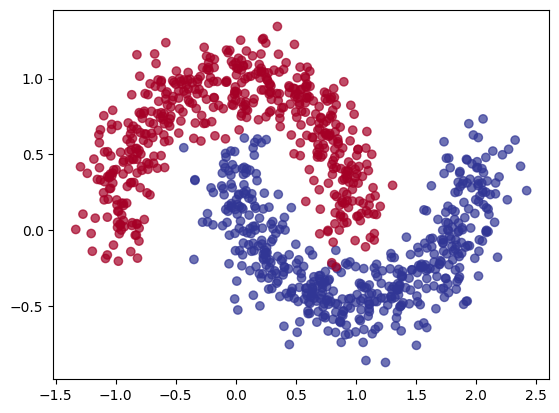

In [1]:
# Create dataset:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
X, y = make_moons(n_samples=1000, noise=0.15, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, alpha=0.7);
# Split data into train and test sets
X_train, y_train = X[:700], y[:700] # 80% of the data for the training set
X_test, y_test = X[700:], y[700:] # 20% of the data for the test set

In [2]:
# Visualize the predictions:

import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [3]:
# Build simple architectures:
import tensorflow as tf

def create_model(
    flatten_shape=None,
    dense_layers=[4,4],
    output_size=1,
    hidden_activ=tf.keras.activations.relu,
    last_activ=tf.keras.activations.sigmoid,
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
    ):
    """
    Creates a ML model using only Dense layers.
    {flatten_shape} [None or List]: if provided, the first layer of the model flattens
    the input to the provided shape.
    {dense_layers} [List]: each element represents the number of neurons for the input and
    hidden layers, in that order.
    {output_size} [Integer]: Number of neurons for the output Dense layer. 
    {hidden_activ} [Tensorflow activation function]: activation function for all layers except
    the last one.
    {last_activ} [Tensorflow activation function]: activation function for the last (output) layer.
    {loss} [Tensorflow loss function]: loss function for the model.
    {optimizer} [Tensorflow optimizer]: optimizer for the model.
    {metrics} [List]: Single element list with the desired metric for the model.
    """
    tf.random.set_seed(42) # Set random seed
    
    # Create the input and hidden layers:
    model = tf.keras.Sequential()
    if flatten_shape is not None:
        model.add(tf.keras.layers.Flatten(input_shape=flatten_shape)),
    for d in dense_layers:
        model.add(tf.keras.layers.Dense(d, activation=hidden_activ))
    model.add(tf.keras.layers.Dense(output_size, activation=last_activ))

    # Compile the model:
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    
    return model 

2025-02-03 13:34:17.792027: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 13:34:17.802332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738600457.813756   21646 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738600457.817133   21646 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 13:34:17.829034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

I0000 00:00:1738600459.562058   21772 service.cc:148] XLA service 0x775378003910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738600459.562263   21772 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-02-03 13:34:19.596897: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738600459.708563   21772 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-03 13:34:19.750109: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 0

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8577 - loss: 0.3063
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
doing binary classifcation...


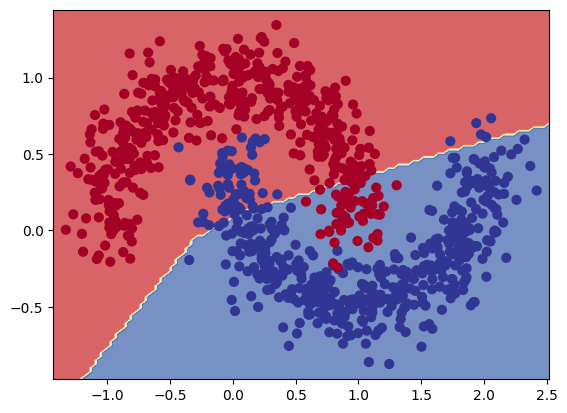

In [4]:
# Create the model:
model_1 = create_model(dense_layers=[4,4],
                       hidden_activ=tf.keras.activations.relu,
                       last_activ=tf.keras.activations.sigmoid,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy']
                       )
# Fit and evaluate:
model_1.fit(X, y, epochs=20, verbose=0) # fit for 100 passes of the data
model_1.evaluate(X,y)
plot_decision_boundary(model_1, X, y)

In [9]:
# Functions for finding good learning rates:

class reset_weights(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super().__init__()

    def on_train_begin(self, logs=None):
        self.init_weights = self.model.get_weights()
        
    def on_epoch_end(self, epoch, logs=None):
        self.model.set_weights(self.init_weights)
        
def find_LR(
    X,y,
    fw_reset=True,rev_reset=True,simple=True,
    flatten_shape=None,
    dense_layers=[4,4],
    output_size=1,
    hidden_activ='relu',
    last_activ='sigmoid',
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer='Adam',
    metrics=['accuracy'],
    epochs=100,
    min_LR=1e-4,
    max_LR=1e1
    ):
    """
    Explore the learning rates in a given range according to three different protocols:
    simple forward learning, and both forward and reverse learning by resetting the internal
    parameters at every epoch.

    --- Inputs ---
    
    {X} [Numpy or Tensorflow array]: predictors for training the model.
    {y} [Numpy or Tensorflow array]: targets for training the model.
    {fw_reset} [Boolean]: if True, uses the forward schedule resetting parameters each epoch.
    {ref_reset} [Boolean]: if True, uses the reverse schedule resetting parameters each epoch.
    {simple} [Boolean]: if True, uses the simple forward schedule.
    {flatten_shape} [None or List]: if provided, the first layer of the model flattens
    the input to the provided shape.
    {dense_layers} [List]: each element is the number of neurons for a Dense layer, in the given order.
    {output_size} [Integer]: Number of neurons for the output Dense layer. 
    {hidden_activ} [Tensforflow activation function]: activation function for all hidden layers.
    {last_activ} [Tensforflow activation function]: activation function for the output layer.
    {loss} [Tensforflow loss function]: loss function.
    {metrics} [Tensforflow metrics]: metrics.
    {epochs} [Integer]: number of epochs during training.
    {min_LR} [float]: minimum learning rate.
    {max_LR} [float]: maximum learning rate.

    --- Return ---

    Outputs are conditioned to the {fw_reset,rev_reset,simple} input options. For each True option,
    the corresponding output is returned. For each False option, a None object is returned.
    
    {history_f} [Tensorflow history callback]: training history for the resetting forward schedule.
    {history_r} [Tensorflow history callback]: training history for the resetting reverse schedule.
    {history_s} [Tensorflow history callback]: training history for the simple forward schedule.
    
    """  
    # Prepare callbacks:
    lr_scheduler_f = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: min_LR * 10**(np.log10(max_LR/min_LR)*epoch/(epochs-1)))
    lr_scheduler_r = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: min_LR * 10**(np.log10(max_LR/min_LR)*(epochs-epoch)/epochs))

    if fw_reset:
        # Forward training schedule:
        model_f = create_model(flatten_shape=flatten_shape,dense_layers=dense_layers,
                               output_size=output_size,hidden_activ=hidden_activ,last_activ=last_activ,
                               loss=loss,optimizer=optimizer,metrics=metrics) # Create the model
        # Fit the model using the forward LR schedule and reset_weights:
        model_f.fit(X,y,epochs=1,verbose=0) # First 1 epoch to start internal params.
        history_f = model_f.fit(X,y,epochs=epochs,callbacks=[lr_scheduler_f,reset_weights()],verbose=0)
    else:
        history_f = None

    if rev_reset:
        # Reverse training schedule:
        model_r = create_model(flatten_shape=flatten_shape,dense_layers=dense_layers,
                               output_size=output_size,hidden_activ=hidden_activ,last_activ=last_activ,
                               loss=loss,optimizer=optimizer,metrics=metrics) # Create the model
        # Fit the model using the reverse LR schedule and reset_weights:
        model_r.fit(X,y,epochs=1,verbose=0) # First 1 epoch to start internal params.
        history_r = model_r.fit(X,y,epochs=epochs,callbacks=[lr_scheduler_r,reset_weights()],verbose=0)    
    else:
        history_r = None

    if simple:
        # Simple training schedule:
        model_s = create_model(flatten_shape=flatten_shape,dense_layers=dense_layers,
                               output_size=output_size,hidden_activ=hidden_activ,last_activ=last_activ,
                               loss=loss,optimizer=optimizer,metrics=metrics) # Create the model
        # Fit the model using the forward LR schedule:
        model_s.fit(X,y,epochs=1,verbose=0) # First 1 epoch to start internal params.
        history_s = model_s.fit(X,y,epochs=epochs,callbacks=[lr_scheduler_f],verbose=0)
    else:
        history_s = None

    return history_f, history_r, history_s

def plot_LR_rates(history_f=None, history_r=None, history_s=None,
                  figsize=(10, 7),ylim=None):
    """
    Plot the learning rate history according to different schedules, if provided:
    simple forward learning, and both forward and reverse learning by resetting the internal
    parameters at every epoch.

    --- Inputs ---

    {history_f} [Tensorflow history callback or None]: training history for the resetting forward schedule.
    {history_r} [Tensorflow history callback or None]: training history for the resetting reverse schedule.
    {history_s} [Tensorflow history callback or None]: training history for the simple forward schedule.
    {figsize} [2-element tuple]: (width, height) sizes for the figure.
    {ylim} [None or 2-element list]: if provided, set the [minimum,maximum] limits for the LR axis.

    --- Return ---

    Plot with the learning rates according to the three different schedules.
    
    """
    # Prepare data:
    if history_f is not None:
        lrs_f, loss_f = history_f.history["learning_rate"], history_f.history["loss"]
    if history_r is not None:        
        lrs_r, loss_r = history_r.history["learning_rate"], history_r.history["loss"]
    if history_s is not None:
        lrs_s, loss_s = history_s.history["learning_rate"], history_s.history["loss"]
        
    # Plot results:
    plt.figure(figsize=figsize)
    if history_f is not None:
        plt.semilogx(lrs_f, loss_f,'o-',label='LR Forward',alpha=0.7)
    if history_r is not None:
        plt.semilogx(lrs_r, loss_r,'s--',label='LR Backwards',alpha=0.7)
    if history_s is not None:
        plt.semilogx(lrs_s, loss_s,'d--',label='LR simple',alpha=0.7)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.legend()
    plt.ylim(ylim)
    plt.title("Learning rate vs. loss");

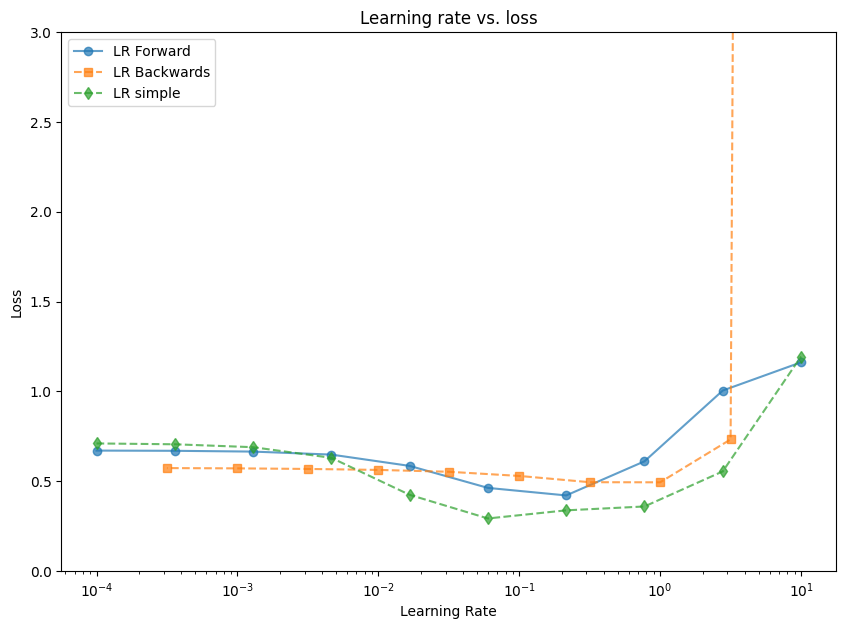

In [12]:
# Find a good learning rate:
history_f, history_r, history_s = find_LR(
    X_train,y_train,
    dense_layers=[4,4],
    output_size=1,
    hidden_activ='relu',
    last_activ='sigmoid',
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer='Adam',
    metrics=['accuracy'],
    epochs=10,
    min_LR=1e-4,
    max_LR=1e1
    )
plot_LR_rates(history_f, history_r, history_s,ylim=[0,3])

From the [green] simple LR schedule (just train progressively using different learning rates), the loss has the sharpest negative slope around 0.002 or 0.01.

From the [blue] forward and [orange] backwards LR schedule (every epoch the model's weights are restored to 'Epoch 1'), the loss has the sharpest negative slope between 0.01 and 0.1. 

I'll keep in mind all criteria and play with LR=[0.001-0.1].

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9674 - loss: 0.0935
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
doing binary classifcation...


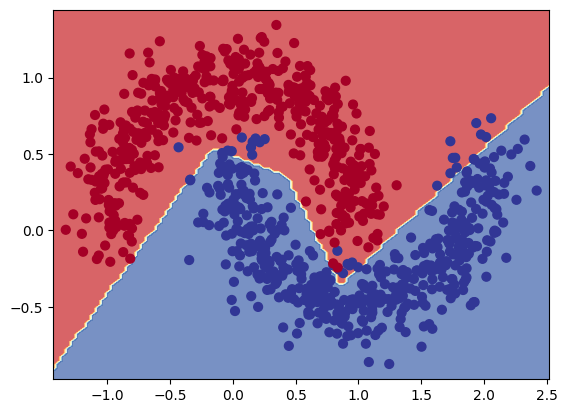

In [14]:
# Train a new model with the chosen LR, for longer:

# Create the model:
model_3 = create_model(dense_layers=[4,4],
                       hidden_activ=tf.keras.activations.relu,
                       last_activ=tf.keras.activations.sigmoid,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.07), # Between 0.01 and 0.1 works best
                       metrics=['accuracy']
                       )

# Fit and evaluate the model:
history_3 = model_3.fit(X_train, y_train, epochs=10,verbose=0)
model_3.evaluate(X_test,y_test)
plot_decision_boundary(model_3, X, y)

## [4] Plotting fashion MNIST

Create a function (or write code) to visualize multiple image predictions for the fashion MNIST at the same time. Plot at least three different images and their prediciton labels at the same time.

In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()
# Correlate numeric labels to article classes:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_examples(data,labels,class_names=None,N=9,unit_size=2,columns=3):
    """
    Visualize image examples from the training dataset along with the ground truth.

    --- Inputs ---
    
    {data} [Numpy]: array containing images, with shape (samples,width,height). Each element
    is a matrix representing an image (sample).
    {labels} [Numpy]: array containing the labels for images, with shape (samples).
    {class_names} [List or None]: if provided, and if {labels} contains integers as labels,
    transform the integer label to the corresponding element in the list.
    {N} [Integer]: number of samples to be randomly plotted.
    {unit_size} [Float]: determines the size for each image display, as a square with
    dimensions {unit_size} x {unit_size}.
    {columns} [Integer]: number of columns in which all images will be organized.

    --- Return ---

    Array of images representing random samples within the provided dataset along with their
    ground truth labels.
    
    """
    # Prepare images and figure layout:
    images = np.random.choice(data.shape[0],size=N,replace='False') # Choose random images
    rows = np.ceil(N/columns).astype(int) # Number of rows
    if N <= columns: # Set number of columns, correct if wrong configuration:
        cols = N
    else:
        cols = columns
    figsize = (cols*unit_size,rows*unit_size)
    # Plot figure:
    fig, axes = plt.subplots(rows,cols,figsize=figsize)
    for i in range(rows*cols):
        row, col = np.ceil((i+1)/cols).astype(int)-1, i % cols # Get current row and column
        if N == 1:
            ax = axes
        elif N == cols or cols == 1:
            ax = axes[i]
        else:
            ax = axes[row][col]
        if i < len(images): # Plots out of range will be blank
            ax.imshow(data[images[i]]) # Plot image in current axis
            label = class_names[labels[images[i]]] if class_names else labels[images[i]] # Get label
            ax.set_title(label)
        ax.axis(False) # Remove XY axes
    fig.tight_layout()

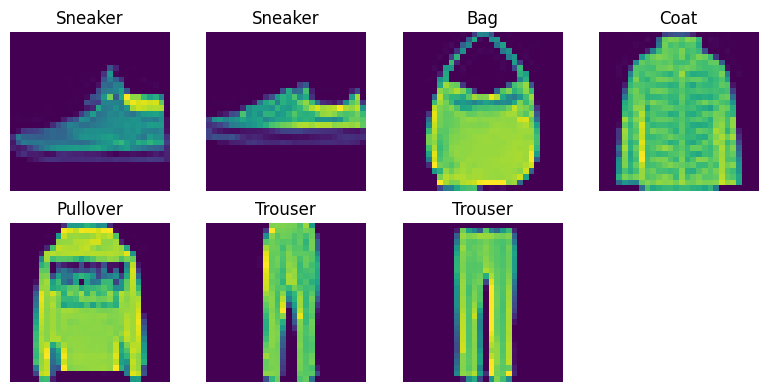

In [17]:
visualize_examples(train_data,train_labels,class_names=class_names,N=7,columns=4,unit_size=2)

### Train a model to identify images:

In [18]:
# First normalize data:
train_data_norm = train_data / 255.0
test_data_norm = test_data / 255.0

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


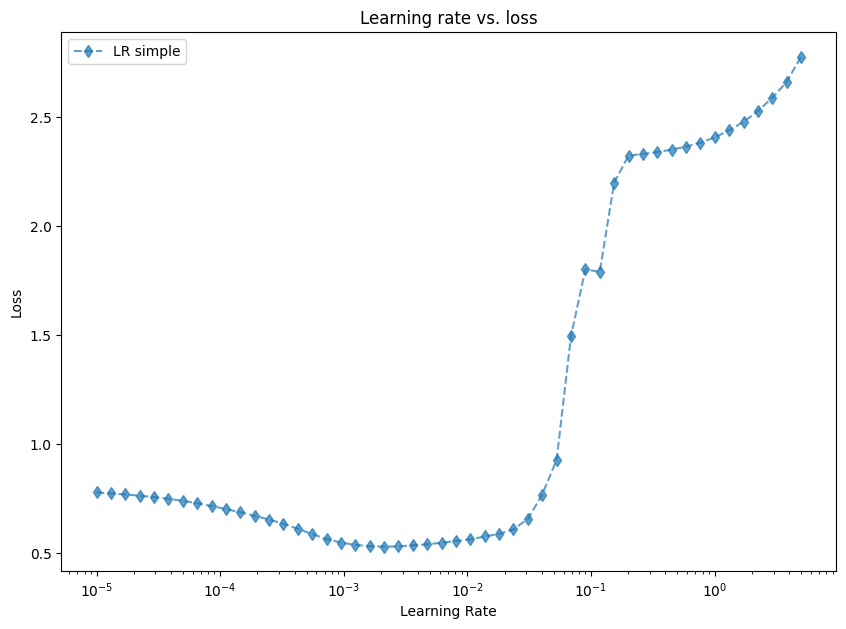

In [19]:
# Find a good learning rate, using only the simple forward schedule:
history_f, history_r, history_s = find_LR(
    train_data_norm,train_labels,
    fw_reset=False, rev_reset=False, simple=True,
    flatten_shape=train_data_norm.shape[1:],
    dense_layers=[4,4],
    output_size=len(class_names),
    hidden_activ='relu',
    last_activ='softmax',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='Adam',
    metrics=['accuracy'],
    epochs=50,
    min_LR=1e-5,max_LR=5e0
    )
plot_LR_rates(history_f, history_r, history_s,ylim=None)

Conclusion: The LR has the greatest slope around 1e-3.
* I will use LR = 1e-3

In [45]:
def plot_acc_vs_epoch(
    history,figsize=(6,4)
    ):
    """
    Plot the accuracy rating as a function of epochs.

    --- Inputs ---

    {history} [Tensorflow history callback or None]: training history.
    {figsize} [2-element tuple]: (width, height) sizes for the figure.

    --- Return ---

    Plot with the accuracy rate as a function of epochs.
    """
    # Idenfity number of epochs and final accuracy:
    N = len(history.history['accuracy']) # Number of epochs
    acc = history.history['accuracy'][-1]*100 # Final accuracy [%]
    
    fig, ax = plt.subplots(figsize=(figsize))
    ax.plot(history.history['accuracy'],'-o',color='teal')
    ax.set(xlabel="Epochs",ylabel="Training Accuracy [%]")
    ax.set_title(f"Training over {N} epochs, final training accuracy: {acc:.2f}%")

In [50]:
# Train a new model with the chosen LR, for longer:

# Create the model:
model_mnist = create_model(
    flatten_shape=train_data_norm.shape[1:],
    output_size=len(class_names),
    dense_layers=[4,4],
    hidden_activ=tf.keras.activations.relu,
    last_activ=tf.keras.activations.softmax,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
    metrics=['accuracy']
    )

# Fit and evaluate the model:
history_mnist = model_mnist.fit(
    train_data_norm, train_labels, epochs=30,verbose=0)
model_mnist.evaluate(test_data_norm,test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8150 - loss: 0.5449


[0.5586190223693848, 0.8079000115394592]

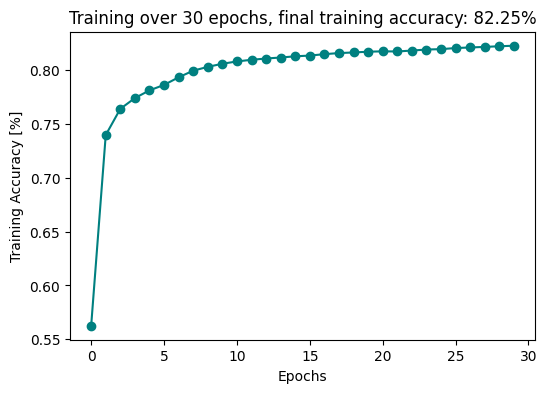

In [51]:
# Plot accuracy as a function of epoch
plot_acc_vs_epoch(history_mnist)

In [95]:
# DEFINE FUNCION TO VISUALIZE EXAMPLES AND PREDICTIONS

def visualize_examples_and_preds(
    data,
    labels,
    model,
    class_names=None,    
    N=9,
    unit_size=2,
    columns=3
    ):
    """
    Visualize image examples along with the ML model predictions and ground truth.

    --- Inputs ---
    
    {data} [Numpy]: array containing images, with shape (samples,width,height). Each element
    is a matrix representing an image (sample).
    {labels} [Numpy]: array containing the labels for images, with shape (samples).
    {model} [Tensorflow object]: Trained model.
    {class_names} [List or None]: if provided, and if {labels} contains integers as labels,
    transform the integer label to the corresponding element in the list.
    {N} [Integer]: number of samples to be randomly plotted.
    {unit_size} [Float]: determines the size for each image display, as a square with
    dimensions {unit_size} x {unit_size}.
    {columns} [Integer]: number of columns in which all images will be organized.

    --- Return ---

    Array of images representing random samples within the provided dataset along with their
    ground truth labels.
    
    """
    # Prepare images and figure layout:
    images = np.random.choice(data.shape[0],size=N,replace='False') # Choose random images
    rows = np.ceil(N/columns).astype(int) # Number of rows
    if N <= columns: # Set number of columns, correct if wrong configuration:
        cols = N
    else:
        cols = columns
    figsize = (cols*unit_size,rows*unit_size)
    # Plot figure:
    fig, axes = plt.subplots(rows,cols,figsize=figsize)
    for i in range(rows*cols):
        row, col = np.ceil((i+1)/cols).astype(int)-1, i % cols # Get current row and column
        if N == 1:
            ax = axes
        elif N == cols or cols == 1:
            ax = axes[i]
        else:
            ax = axes[row][col]
        if i < len(images): # Plots out of range will be blank
            # Identify ground truth:
            GT_label = class_names[labels[images[i]]] if class_names else labels[images[i]] # Get label
            # Predict label and check if it is correct:
            pred_probs = model.predict(np.expand_dims(data[images[i]],axis=0))
            confidence = 100*tf.reduce_max(pred_probs) # [%]
            if class_names is not None:
                pred_label = class_names[pred_probs.argmax()]
            else:
                pred_label = pred_probs.argmax()
            pred_color = 'green' if pred_label == GT_label else 'red'
            
            # Plot image, prediction and verdict:
            ax.imshow(data[images[i]]) # Plot image in current axis
            if pred_label == GT_label:
                title = f"Pred: {pred_label}, {confidence:.0f}% | Correct!"
            else:
                title = f"Pred: {pred_label}, {confidence:.0f}% | True: {GT_label}"
            ax.set_title(title,color=pred_color,size=8)
        ax.axis(False) # Remove XY axes
    fig.suptitle(f"Overall accuracy: {model.evaluate(data,labels)[1]*100:.1f}%")
    fig.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.8148 - loss: 0.5454


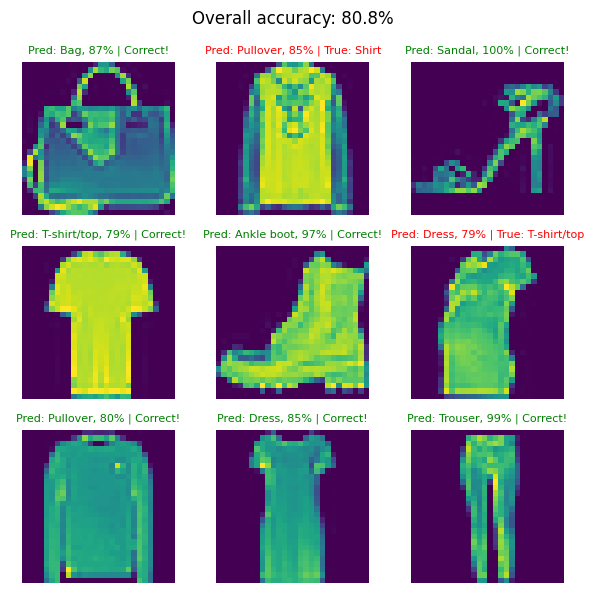

In [98]:
visualize_examples_and_preds(
    test_data_norm,test_labels,model_mnist,class_names=class_names,
    N=9,columns=3,unit_size=2
    )

## Extra curriculum 📖
* Watch 3Blue1Brown's neural networks video 2: [*Gradient descent, how neural networks learn*](https://www.youtube.com/watch?v=IHZwWFHWa-w). After you're done, write 100 words about what you've learned.
  * If you haven't already, watch video 1: [*But what is a Neural Network?*](https://youtu.be/aircAruvnKk). Note the activation function they talk about at the end.
* Watch [MIT's introduction to deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) (if you haven't already) to get an idea of the concepts behind using linear and non-linear functions.
* Spend 1-hour reading [Michael Nielsen's Neural Networks and Deep Learning book](http://neuralnetworksanddeeplearning.com/index.html).
* Read the [ML-Glossary documentation on activation functions](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html). Which one is your favourite?
  * After you've read the ML-Glossary, see which activation functions are available in TensorFlow by searching "tensorflow activation functions".